# 6 - Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

Î™®Îç∏ Íµ¨ÌòÑ Î∞è inferenceÏóê ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î∂àÎü¨Ïò§Îäî ÏΩîÎìúÏù¥Îã§. Ï†ÄÎ≤à Í≥ºÏ†úÏôÄ ÎßàÏ∞¨Í∞ÄÏßÄÎ°ú Muti30K Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌôúÏö©Ìï¥ÏÑú ÎèÖÏùºÏñ¥Î•º ÏòÅÏñ¥Î°ú Î≤àÏó≠ÌïòÎäî taskÎ•º ÏàòÌñâÌïúÎã§. Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÎ≥¥Îäî Îã§ÏùåÍ≥º Í∞ôÎã§.

train: 29000

valid: 1014

test: 1000

ÏïΩ 3ÎßåÏó¨Í∞úÏùò ÏòÅÏñ¥, ÎèÖÏùºÏñ¥ Î¨∏Ïû•ÏúºÎ°ú Íµ¨ÏÑ±ÎêòÏñ¥ÏûàÏúºÎ©∞, Î¨∏Ïû• Îãπ ÌèâÍ∑† Îã®Ïñ¥(token)ÏàòÎäî 13Í∞ú Ï†ïÎèÑÏù¥Îã§.

## 1. ÌïÑÏöîÌïú Î™®Îìà Î∂àÎü¨Ïò§Í∏∞

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

## 2. random seed ÏÑ§Ï†ï

In [55]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Í≥†Ï†ï Ìï† ÎûúÎç§ÏãúÎìúÎ•º ÏÑ†Ïñ∏ÌïúÎã§. numpyÏôÄ torchÏóê Ï†ÅÏö©ÎêúÎã§.

We'll then create our tokenizers as before.

## 3. Îç∞Ïù¥ÌÑ∞ÏÖã Î∂àÎü¨Ïò§Í∏∞ Î∞è Ï†ÑÏ≤òÎ¶¨

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

spacy ÎÇ¥ Íµ¨ÌòÑÎêú english tokenizerÏôÄ ÎèÖÏùºÏñ¥ tokenizerÎ•º loadÌïúÎã§. Ïù¥ÌõÑ Ï†ïÏùòÎêú Ìï®ÏàòÎì§ÏùÄ ÏûÖÎ†•Îêú textÎ•º tokenizerÎ•º ÏÇ¨Ïö©Ìï¥ÏÑú tokenÏúºÎ°ú Î∂ÑÎ¶¨Ìïú ÌõÑ, Î¶¨ÌÑ¥ÌïòÎäî ÏΩîÎìúÏù¥Îã§.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

ÏÇ¨Ïö©Ïûê Ï†ïÏùòÌï®ÏàòÎ•º tokenizerÎ°ú Ïì∞Í≥†, init_tokenÍ≥º eos_tokenÏùÑ ÏÑ†Ïñ∏ÌïòÎäî Field Í∞ùÏ≤¥Ïù¥Îã§. Ïù¥Îïå transformerÏùò input shpaeÏùÑ Í≥†Î†§Ìï¥ÏÑú batch_firstÎ•º True Ìï¥Ï§ÄÎã§.

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

Ï†ïÏùòÌïú ÌïÑÎìúÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ train, valid, testÎ°ú Î∂ÑÎ¶¨ÌïòÎäî ÏΩîÎìúÏù¥Îã§. Ïù¥Îïå ÌïÑÎìúÎäî sourceÏôÄ targetÏóê ÎåÄÌï¥ Í∞ÅÍ∞Å Îã§Î•¥Í≤å Ï†ÅÏö©ÎêúÎã§.

## 4. Îã®Ïñ¥ÏÇ¨Ï†Ñ ÏÉùÏÑ±

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [66]:
print('SRC Îã®Ïñ¥ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞ :', len(SRC.vocab))
print(SRC.vocab.stoi)

SRC Îã®Ïñ¥ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞ : 7853
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f838a705fd0>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, '.': 4, 'ein': 5, 'einem': 6, 'in': 7, 'eine': 8, ',': 9, 'und': 10, 'mit': 11, 'auf': 12, 'mann': 13, 'einer': 14, 'der': 15, 'frau': 16, 'die': 17, 'zwei': 18, 'einen': 19, 'im': 20, 'an': 21, 'von': 22, 'sich': 23, 'dem': 24, 'm√§dchen': 25, 'junge': 26, 'vor': 27, 'zu': 28, 'steht': 29, 'm√§nner': 30, 'sitzt': 31, 'hund': 32, 'den': 33, 'stra√üe': 34, 'w√§hrend': 35, 'gruppe': 36, 'h√§lt': 37, 'spielt': 38, 'das': 39, 'hemd': 40, 'personen': 41, '√ºber': 42, 'drei': 43, 'eines': 44, 'frauen': 45, 'blauen': 46, 'neben': 47, 'ist': 48, 'kind': 49, 'roten': 50, 'wei√üen': 51, 'stehen': 52, 'sitzen': 53, 'menschen': 54, 'am': 55, 'aus': 56, 'spielen': 57, 'durch': 58, 'bei': 59, 'geht': 60, 'tr√§gt': 61, 'f√§hrt': 62, 'wasser': 63, 'um': 64, 'kinder': 65, 'kleines': 66, 'person': 67, 'macht': 68, 

In [67]:
print('TRG Îã®Ïñ¥ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞ :', len(TRG.vocab))
print(TRG.vocab.stoi)

TRG Îã®Ïñ¥ÏÇ¨Ï†Ñ ÌÅ¨Í∏∞ : 5893
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f837710ae80>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, 'a': 4, '.': 5, 'in': 6, 'the': 7, 'on': 8, 'man': 9, 'is': 10, 'and': 11, 'of': 12, 'with': 13, 'woman': 14, ',': 15, 'two': 16, 'are': 17, 'to': 18, 'people': 19, 'at': 20, 'an': 21, 'wearing': 22, 'shirt': 23, 'young': 24, 'white': 25, 'black': 26, 'his': 27, 'while': 28, 'blue': 29, 'men': 30, 'red': 31, 'sitting': 32, 'girl': 33, 'boy': 34, 'dog': 35, 'standing': 36, 'playing': 37, 'group': 38, 'street': 39, 'down': 40, 'walking': 41, '-': 42, 'front': 43, 'her': 44, 'holding': 45, 'one': 46, 'water': 47, 'three': 48, 'by': 49, 'women': 50, 'up': 51, 'green': 52, 'little': 53, 'for': 54, 'child': 55, 'looking': 56, 'outside': 57, 'as': 58, 'large': 59, 'through': 60, 'brown': 61, 'yellow': 62, 'children': 63, 'person': 64, 'from': 65, 'their': 66, 'hat': 67, 'ball': 68, 'into': 69, 'small': 7

ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï Ïù¥ÌõÑ Í∞Å Í≥†Ïú† ÌÜ†ÌÅ∞Ïóê ÎåÄÌï¥ Ï†ïÏàòÏù∏ÏΩîÎî©ÏùÑ ÏßÑÌñâÌï¥ÏÑú  Îã®Ïñ¥ÏÇ¨Ï†ÑÏùÑ ÎßåÎì†Îã§. 

## 5. Îç∞Ïù¥ÌÑ∞Î°úÎçî Ï†ïÏùò

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU ÏÇ¨Ïö©Ïù¥ Í∞ÄÎä•ÌïòÎ©¥ gpu, ÏïÑÎãàÎ©¥ cpuÎ•º ÏÇ¨Ïö©ÌïúÎã§.

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

Îç∞Ïù¥ÌÑ∞Îì§ÏùÑ Îã¥ÏïÑÎÜìÏùÄ BucketÏóêÏÑú BATCH_SIZEÎßåÌÅº Î™®ÏïÑÏßÄÎèÑÎ°ù Îç∞Ïù¥ÌÑ∞Î•º ÎΩëÏïÑÏ£ºÎäî BucketIteratorÎ°ú splitÌïúÎã§.

## 6. Transformer Î™®Îç∏ Íµ¨Ï°∞

### Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

#### Encoder


![](assets/transformer-encoder.png)



Ìä∏ÎûúÏä§Ìè¨Î®∏Ïùò Ïù∏ÏΩîÎçîÎäî Ï†ïÏàòÏù∏ÏΩîÎî© Îêú Î¨∏Ïû•ÏùÑ inputÏúºÎ°ú Î∞õÎäîÎã§. Ïù¥Îïå Multi-head attention layerÎ°ú Îì§Ïñ¥Í∞ÄÍ∏∞ Ï†Ñ, ÎëêÍ∞ÄÏßÄ Îã®Í≥ÑÏùò embedding layerÍ∞Ä Ï°¥Ïû¨ÌïúÎã§. 

1.token embedding layer : token embeddingÌïòÎäî ÏùºÎ∞òÏ†ÅÏù∏ layer [batch size x seq_len x d_model]

2.positional embedding layer : Í∞Å ÌÜ†ÌÅ∞Ïùò ÏúÑÏπòÏ†ïÎ≥¥Î•º ÎÑ£Ïñ¥Ï£ºÍ∏∞ ÏúÑÌïú layer [batch size x seq_len x d_model]



Ï†ïÏàòÏù∏ÏΩîÎî© Îêú input Îç∞Ïù¥ÌÑ∞Îäî token embedding layerÎ•º Í±∞Ï≥êÏÑú ùëë_ùëöùëúùëëùëíùëôÏùò dimension sizeÎ•º Í∞ÄÏßÄÎäî token embedding vectorÎ°ú Î≥ÄÌôòÏù¥ ÎêòÍ≥†, ÏûÖÎ†• Î¨∏Ïû•Ïùò max_lengthÏóê Îî∞ÎùºÏÑú positional embedding vectorÎ•º ÏÉùÏÑ±, token embedding vectorÏôÄ Ìï©Ìï¥ÏßÑÎã§. Ïù¥Îïå Ìï©Ï≥êÏßÄÍ∏∞ Ï†Ñ, token embedding vectorÎäî scaling factorÏù∏ hidden_dimÏùò Ï†úÍ≥±Í∑ºÏùÑ Í≥±Ìïú Îí§ Ìï©Ìï¥ÏßÄÎäîÎç∞, Ïù¥ Í≥ºÏ†ïÏùÑ Í±∞ÏπòÎäî Ïù¥Ïú†Îäî embedding ÎÇ¥ varianceÎ•º Ï§ÑÏù¥Í≥† Î™®Îç∏Ïù¥ ÌïôÏäµÏùÑ Îçî Ïûò Ìï† Ïàò ÏûàÎèÑÎ°ù ÎèïÍ∏∞ ÏúÑÌï®Ïù¥Îã§. Í≤∞Í≥ºÏ†ÅÏúºÎ°ú Ìï©Ìï¥ÏßÑ embedding vectorÏóê dropout layerÍ∞Ä Ï†ÅÏö© Îêú Îí§ mutl head attention layerÏùò inputÏúºÎ°ú ÏÇ¨Ïö©ÎêúÎã§. Ïù¥Îïå Ïù∏ÏΩîÎçîÏóêÏÑúÎäî ÎßàÏä§ÌÇπÏùÑ ÏßÑÌñâÌïòÎäîÎç∞ Ïù¥Îäî Ìå®Îî© ÎßàÏä§ÌÇπÏù¥Îã§.


In [68]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

Encoder classÏóêÏÑú ÏûÖÎ†•Î∞õÎäî hyperparameterÎäî Îã§ÏùåÍ≥º Í∞ôÎã§.

* input dim: input tokenÏúºÎ°ú Íµ¨ÏÑ±Ìïú Îã®Ïñ¥ÏÇ¨Ï†ÑÏùò dimensionÏùÑ ÏùòÎØ∏ÌïúÎã§. Ï¶â,src_tokenÏùò vocab sizeÍ∞Ä ÎêúÎã§.

* hid_dim: ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Ïùò dimensionÏùÑ ÏùòÎØ∏ÌïúÎã§. original transformerÏóêÏÑúÎäî 512Î°ú ÏÇ¨Ïö©ÌïúÎã§.

* n_layers: Ïù∏ÏΩîÎçî, ÎîîÏΩîÎçîÏùò Í∞úÏàòÎ•º ÏùòÎØ∏ÌïúÎã§.

* n_heads:Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâÏãú ÏÇ¨Ïö©ÌïòÎäî Ìó§ÎìúÏùò Í∞úÏàòÎ•º ÏùòÎØ∏ÌïúÎã§.

* pf_dim: Ïù∏ÏΩîÎçî ÎîîÏΩîÎçî ÎÇ¥ ÌîºÎìúÌè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò dimension ÌÅ¨Í∏∞Î•º ÏùòÎØ∏ÌïúÎã§.

* dropout:ÌäπÏ†ï featureÏóê ÎåÄÌï¥ Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÍ∏∞ ÏúÑÌïú dropout ÎπÑÏú®ÏùÑ ÏùòÎØ∏ÌïúÎã§.

* device: cpu, gpu Ï§ë ÏÑ†ÌÉùÌï¥ÏÑú ÏÇ¨Ïö©ÌïúÎã§.

* max_length:ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÌïòÎäî ÏãúÌÄÄÏä§Ïùò ÏµúÎåÄ Í∏∏Ïù¥Î•º ÏùòÎØ∏ÌïúÎã§.

Encoder ÌÅ¥ÎûòÏä§ÏóêÏÑúÎäî input_dimÏùÑ hidden_dimÏúºÎ°ú Î∞îÍøîÏ£ºÎäî ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥ÏôÄ ÏãúÌÄÄÏä§ ÎÇ¥ Í∞Å ÌÜ†ÌÅ∞ Î≥Ñ ÏúÑÏπò Ï†ïÎ≥¥Î•º ÏïåÎ†§Ï£ºÎäî positional ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨ÌïúÎã§.  
<br>
ÎòêÌïú Ïù∏ÏΩîÎçîÏùò ÏÑ∏Î∂Ä Î†àÏù¥Ïñ¥Îì§Ïóê ÎåÄÌï¥ÏÑú Ï†ïÏùòÎêú nn.ModuleList()Í∞Ä self.layer() ÌòïÌÉúÎ°ú Ï†ïÏùòÎêòÏñ¥ ÏûàÏúºÎ©∞ self.scaleÏùÄ hid_dim ÌÅ¨Í∏∞Ïùò Ï†úÍ≥±Í∑º ÎßåÌÅº Ïä§ÏºÄÏùºÎßÅ Ìï¥Ï£ºÎäî Ïó≠Ìï†ÏùÑ ÌïúÎã§.  
<br>
input ÏãúÌÄÄÏä§Îäî token embedding layerÎ•º ÌÜµÌï¥ ÏûÑÎ≤†Îî© Î≤°ÌÑ∞Î°ú Î≥ÄÌôòÎêòÍ≥† Ïó¨Í∏∞Ïóê Ïä§ÏºÄÏùºÎßÅ Í∞íÏùÑ Í≥±Ìï¥Ï§Ä Îí§ positional ÏûÑÎ≤†Îî©Í≥º ÎçîÌï¥ÏßÑÎã§. Ïù¥ÌõÑ dropoutÏùÑ Í±∞Ï≥ê encoder layerÏùò ÏßÅÏ†ëÏ†ÅÏù∏ inputÏù∏ srcÎ•º ÏÉùÏÑ±ÌïúÎã§.  
<br>
ÏÉùÏÑ±Îêú srcÎäî forÎ¨∏ÏùÑ ÌÜµÌï¥ Í∞Å ÏÑ∏Î∂Ä encoder layerÎ•º ÌÜµÍ≥ºÌï¥ÏÑú Í≤∞Í≥ºÎ•º Î¶¨ÌÑ¥ÌïúÎã§.

### Encoder Layer



* ÌïòÎÇòÏùò encoder layerÏóêÎäî Multi-head self-attention layer, residual connection & layer normalization, position-wise feedworad layerÍ∞Ä Ï°¥Ïû¨ÌïúÎã§. 
* ÏûÖÎ†• ÏãúÌÄÄÏä§ÏôÄ ÎßàÏä§ÌÇπ Ï†ïÎ≥¥Îäî multi-head attentionÏùÑ ÏàòÌñâÌïòÍ≥† Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÍ∞íÏùÑ ÏÇ∞Ï∂úÌïúÎã§.  
* Ïù¥Îïå Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÎäî srcÏùò dimensionÍ≥º ÎèôÏùºÌïòÍ≤å hid_dimÏùÑ Í∞ÄÏßÑÎã§. Ìó§ÎìúÎ•º Ïó¨Îü¨Í∞ú ÏÇ¨Ïö©Ìï¥ÎèÑ Í∞ôÎã§.
* Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÍ∞íÏùÄ src ÏûÑÎ≤†Îî©Í≥º ÎçîÌï¥ÏßÄÎäî residual connectionÍ≥ºÏ†ïÏùÑ Í±∞ÏπòÍ≥†, layer normalizationÏùÑ ÌÜµÌï¥ feature Í∞í ÎÅºÎ¶¨ Ï†ïÍ∑úÌôîÎêòÎäî Ïó∞ÏÇ∞ÏùÑ ÏàòÌñâÌïúÎã§.  
* Ïù¥ÌõÑ fully-connected layerÏù∏ position-wise feedfowrad layerÎ•º ÌÜµÍ≥ºÌïúÎã§. ÌîºÎìúÌè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò dimensionÏùÄ Î≥¥ÌÜµ hid_dimÎ≥¥Îã§ ÌÅ¨Îã§. Ïù¥Îïå ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò ÌååÎùºÎ©îÌÑ∞Îäî ÌïòÎÇòÏùò Ï∏µÏóêÏÑú ÏûÖÎ†•Ïù¥ Îã¨ÎùºÏßà Îïå ÎèôÏùºÌïú Í∞íÏù¥ Ï†ÅÏö©ÎêòÍ≥† Ïù∏ÏΩîÎçî Ï∏µÎßàÎã§Îäî Îã¨ÎùºÏßÑÎã§.


In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

- Encoderlayer ÌÅ¥ÎûòÏä§ÏóêÏÑú Ïó≠Ïãú Encoder ÌÅ¥ÎûòÏä§ÏôÄ ÎèôÏùºÌïú ÌååÎùºÎ©îÌÑ∞Î°ú Ï¥àÍ∏∞Ìôî ÎêúÎã§. ÎòêÌïú Ïù∏ÏΩîÎçî ÎÇ¥Î∂ÄÎ•º Íµ¨ÏÑ±ÌïòÎäî ÏÖÄÌîÑÏñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥, ÌîºÎìúÌè¨ÏõåÎìú Î†àÏù¥Ïñ¥, Í∑∏Î¶¨Í≥† Í∞Å Î†àÏù¥Ïñ¥ ÏúóÎã®Ïóê ÏÇ¨Ïö©ÎêòÎäî ÏûîÏ∞®Ïó∞Í≤∞ Î∞è Î†àÏù¥Ïñ¥ Ï†ïÍ∑úÌôî Ï∏µÏù¥ ÏÑ†Ïñ∏ÎêúÎã§.  
  
  
- foward Ìï®ÏàòÎ•º ÏÇ¥Ìé¥Î≥¥Î©¥ self.self_attention()Ïùò ÏûÖÎ†•ÏúºÎ°ú src 3Í∞úÏôÄ src_mask 1Í∞úÍ∞Ä ÏûàÎäîÎç∞, Ïù¥Îäî Ïñ¥ÌÖêÏÖòÏóê ÏÇ¨Ïö©Ìï† key, query, valueÎ•º ÎßåÎì§Í∏∞ÏúÑÌïú ÏûÖÎ†•ÏúºÎ°ú Ï£ºÏñ¥ÏßÄÎäî Í≤ÉÏù¥Îã§. src_maskÏùò Í≤ΩÏö∞, Ïñ¥ÌÖêÏÖò Í≤∞Í≥º(energy)Ïóê ÎßàÏä§ÌÇπÏùÑ Ï£ºÍ∏∞ ÏúÑÌï¥ ÏûÖÎ†•ÌïúÎã§.  


- Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÍ∞íÏùÄ [batch_size, seq len, hid dim]Ïùò shapeÏùÑ Í∞ÄÏßÄÎ©∞, ÎìúÎ°≠ÏïÑÏõÉ Î†àÏù¥Ïñ¥Î•º Í±∞Ïπú Îí§ inputÍ≥º element-wise sum ÎêòÏñ¥ ÏûîÏ∞® Ïó∞Í≤∞ÏùÑ Ïù¥Î£¨Îã§. Ïù¥ÌõÑ self.self_attn_layer_norm()ÏùÑ ÌÜµÌï¥ layer normalizationÏùÑ Îêú Í≤∞Í≥ºÎ•º Ï∂úÎ†•ÌïúÎã§. Ïù¥Îïå Ïó≠Ïãú Îç∞Ïù¥ÌÑ∞Ïùò shapeÏùÄ encoder layerÏóê Îì§Ïñ¥Í∞ÄÍ∏∞ Ï†Ñ srcÏôÄ ÎèôÏùºÌïòÎã§.

- Ïù¥ÌõÑ Ï∂úÎ†• Í∞íÏùÄ position wise feedworad layerÎ°ú Îì§Ïñ¥Í∞ÄÍ≤å ÎêòÍ≥† hid dim Ï∞®ÏõêÏùò Î≤°ÌÑ∞Îäî Î†àÏù¥Ïñ¥ ÏïàÏóêÏÑú pf_dim ÌÅ¨Í∏∞Î°ú Î≥ÄÌôòÎêòÎäîÎç∞ Ï∂úÎ†•ÏãúÏóêÎäî Îã§Ïãú hid dimÏúºÎ°ú Î≥ÄÌôòÎêòÏñ¥ Ï∂úÎ†•ÎêúÎã§. Ïù¥Îïå Ïó≠Ïãú Ïñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥ÏôÄ ÎèôÏùºÌïòÍ≤å ÎìúÎ°≠ÏïÑÏõÉÍ≥º ÏûîÏ∞®Ïó∞Í≤∞, Î†àÏù¥Ïñ¥ ÎÖ∏ÎßêÎùºÏù¥Ï†úÏù¥ÏÖòÏù¥ Ï†ÅÏö©ÎêúÎã§.

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

- ÏÜåÍ∞úÎêòÎäî Î©ÄÌã∞Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùÄ ÏãúÌÄÄÏä§ ÎÇ¥ Îì±Ïû•ÌïòÎäî Î™®Îì† Îã®Ïñ¥ Î≤°ÌÑ∞ srcÎ•º weight matrixÎ•º ÌÜµÍ≥ºÏãúÏºú Í∞ÅÍ∞Å key, query, valueÎ•º ÏñªÏùåÏúºÎ°úÏç® Ï≤´ ÌîÑÎ°úÏÑ∏Ïä§Í∞Ä ÏßÑÌñâ ÎêúÎã§.  

- Ïù¥Îïå Î©ÄÌã∞ Ìó§ÎìúÏùò Í∞úÎÖêÏùÄ ÌäπÏ†ï featureÏóê ÏπòÏö∞Ï≥êÏÑú Îã®Ïñ¥ÏÇ¨Ïù¥Ïùò Í¥ÄÍ≥ÑÎ•º Î≥¥ÏßÄ ÏïäÍ≥†, Îã§ÏñëÌïú ÏãúÍ∞ÅÏóêÏÑú Îã®Ïñ¥ ÏÇ¨Ïù¥Ïùò Í¥ÄÍ≥ÑÎ•º Î≥¥Í≤†Îã§Îäî ÏùòÎØ∏Ïù¥Îã§. Îî∞ÎùºÏÑú Ìó§Îìú Ïàò ÎßåÌÅº K, Q, V matrixÍ∞Ä Ï°¥Ïû¨ÌïòÍ≥†, weight matrixÎ•º ÌÜµÍ≥ºÌïú Î≤°ÌÑ∞Ïùò Ï∞®ÏõêÏùÄ hid_dimÏóêÏÑú hid_dim/num_head = head_dim ÌÅ¨Í∏∞Î°ú Î≥ÄÌôòÎêúÎã§.

- ÎΩëÌûå K, Q metrixÎäî  Îëò Ï§ë ÌïòÎÇòÏùò ÌñâÎ†¨ÏùÑ Ï†ÑÏπòÏãúÌÇ® Îí§ ÌñâÎ†¨ Í∞Ñ Í≥±ÏùÑ ÌÜµÌï¥ÏÑú Ïñ¥ÌÖêÏÖò Ïä§ÏΩîÏñ¥Î•º ÏÇ∞Ï∂úÌïòÍ≥† Ïù¥Îäî head_dimÏùò Ï†úÍ≥±Í∑ºÏúºÎ°ú ÎÇòÎà†ÏßÑÎã§. Ìï¥Îãπ Í≥ºÏ†ï ÎïåÎ¨∏Ïóê Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖòÏù¥ÎùºÎäî Ïù¥Î¶ÑÏúºÎ°ú Î∂àÎ¶¨Ïö∞Í≤å ÎêòÏóàÎã§.

- ÏúÑ Í≥ºÏ†ïÏùÑ Í±∞Ïπú Í≤∞Í≥ºÎ¨ºÏù∏ energyÎäî ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÌÜµÌï¥ attention weightÎ°ú ÌëúÌòÑÏù¥ ÎêòÎ©∞, keyÏôÄ query ÎÇ¥ Í∞ÅÍ∞ÅÏùò token ÏÇ¨Ïù¥Ïùò Í¥ÄÍ≥ÑÎ•º ÎÇòÌÉÄÎÇ¥Îäî Ïä§ÏπºÎùº Í∞íÏùÑ Í∞ÄÏßÑÎã§.

- Ìï¥Îãπ Í∞íÏùÄ Value matrixÏôÄ Í≥±Ìï¥Ï†∏ÏÑú Í∞Å Ìó§Îìú Î≥Ñ Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÎ•º ÏÇ∞Ï∂úÌïòÍ≤å ÎêúÎã§.

- Í∞Å Ìó§ÎìúÎì§Ïùò Í≤∞Í≥ºÎ¨ºÏùÄ Îã§Ïãú hid_dim ÌÅ¨Í∏∞Ïùò matrixÎ°ú ÌëúÌòÑÎêòÍ∏∞ ÏúÑÌï¥ÏÑú ÏÑúÎ°ú concat ÎêúÎã§.Î™®Îëê Ïó∞Í≤∞Îêú matrixÎäî fc layerÏùò hid_dim x hid dim Í∞ÄÏ§ëÏπò ÌñâÎ†¨Í≥º Í≥±Ìï¥Ï†∏ÏÑú [batch size x seq_len x hid dim] shapeÏùò Í≤∞Í≥ºÎ•º Ï∂úÎ†•ÌïúÎã§.

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

Multihead attention ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ ÏΩîÎìúÏù¥Îã§.  

- hid_dim % num_heads ÎÇòÎ®∏ÏßÄÎäî 0Ïù¥ÎùºÍ≥† ÏßÄÏ†ïÌïòÍ≥†, hid dim, num_heads, head_dimÏùÑ ÌïÑÎìúÎ°ú Î∞õÎäîÎã§.
- ÎòêÌïú q, k, vÎ•º ÎßåÎì§Í∏∞ ÏúÑÌï¥ Í∞ÅÍ∞ÅÏùò linear layerÎ•º ÏÑ†Ïñ∏ÌïúÎã§ Ïó∞ÏÇ∞ ÎßàÏßÄÎßâÏóê Ï†ÅÏö©ÌïòÎäî fc Ïó≠Ïãú ÏÑ†Ïñ∏ÌïúÎã§. Ïù¥Îïå input, output shapeÏùÄ hid dimÏúºÎ°ú ÎèôÏùºÌïòÎã§. Ïù¥ÌõÑ dropout layerÏôÄ scale ÌïÑÎìúÎ•º ÏÑ†Ïñ∏ÌïúÎã§.  


- foward Î∂ÄÎ∂ÑÏóêÏÑúÎäî Í∞ÅÍ∞ÅÏùò weight matrixÏóê Ïù∏ÌíãÏùÑ ÌÉúÏõå q, k, vÎ•º ÎßåÎì†Îã§. Ïù¥ÌõÑ Îß§Ìä∏Î¶≠Ïä§Í∞Ñ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌï¥ÏÑú view Ìï®ÏàòÏôÄ permuteÌï®ÏàòÎ•º ÌÜµÌï¥ Í∞Å matrixÏùò shapeÏùÑ Î≥ÄÍ≤ΩÌï¥Ï§ÄÎã§. => [batch size, n heads, (), head dim] : ()Îäî Í∞ÅÍ∞Å query len, key len, value len Ïù¥Îã§.  


- Ïù¥ÌõÑ QÏôÄ KÎ•º ÌñâÎ†¨Í≥±ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú KÎ•º [batch size, n_heads, head dim, key len] shapeÏúºÎ°ú Î≥ÄÍ≤ΩÌï¥Ï§ÄÎã§. Ìï¥Îãπ Î≥ÄÍ≤ΩÏùÄ permute() Ìï®ÏàòÍ∞Ä ÏàòÌñâÌïúÎã§.  
- Î≥ÄÍ≤Ω ÌõÑÏóêÎäî Q ( query_len x head dim) x K( head_dim x key_len ) = [batch size, n_heads, query len, key len] shapeÏùò matrixÍ∞Ä Í≥ÑÏÇ∞ÎêòÏñ¥ Í∞Å token pair Î≥Ñ relationshipÏù¥ Ï∂úÎ†•ÎêòÍ≥†, Ïó¨Í∏∞Ïóê head_dimÏùò Ï†úÍ≥±Í∑ºÏù∏ self.scaleÏùÑ ÎÇòÎà† Ï£ºÏñ¥ energyÎ•º Íµ¨ÌïúÎã§.  

- ÌäπÏ†ï ÏúÑÏπòÏùò masking Ï†ïÎ≥¥Í∞Ä 0Ïù¥Î©¥ energy matrixÏóêÏÑúÏùò Ìï¥Îãπ ÏúÑÏπòÍ∞íÏùÑ Îß§Ïö∞ÏûëÏùÄ Ïã§ÏàòÎ°ú Î∞îÍæ∏Ïñ¥ ÎßàÏä§ÌÇπÌïúÎã§.  

- Value matrixÎäî ÎßàÏä§ÌÇπÎêú energy Í∞íÏóê ÎìúÎ°≠ÏïÑÏõÉ Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥ºÏãúÌÇ® matrixÏôÄ ÌñâÎ†¨Í≥±ÏùÑÌïòÍ≥† Ïù¥ÎïåÏùò shapeÏùÄ [batch_size, n heads, query len, head dim]Ïù¥Îã§. multihead self attentionÏóêÏÑú query len == value len == key len Ïù¥Îã§.  

- Ïù¥ÌõÑ shape Î≥ÄÍ≤ΩÏùÑ ÌÜµÌï¥ÏÑú matrixÎäî [batch size, query len , hid dim]Ïùò shapeÏùÑ Í∞ñÍ≤å ÎêúÎã§.

- ÎßàÏßÄÎßâÏúºÎ°ú output fc layerÎ•º ÌÜµÍ≥ºÏãúÏºú Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ Í≤∞Í≥º matrixÎ•º Ï∂úÎ†•ÌïúÎã§. Ïù¥Îïå fc layerÏùò weight matrixÎäî [hid_dim x hid dim]Ïù¥Îã§.


### Position-wise Feedforward Layer



- Ìè¨ÏßÄÏÖò ÏôÄÏù¥Ï¶à ÌîºÎìúÌè¨ÏõåÎìú Î†àÏù¥Ïñ¥Îäî Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥ Ïù¥ÌõÑÏóê ÏûîÏ∞®Ïó∞Í≤∞Í≥º Î†àÏù¥Ïñ¥ ÎÖ∏ÎßêÎùºÏù¥Ï†úÏù¥ÏÖòÏùÑ Í±∞Ïπú Îß§Ìä∏Î¶≠Ïä§Î•º Ïù∏ÌíãÏúºÎ°ú Î∞õÎäîÎã§.  


- Ìï¥Îãπ Ïã†Í≤ΩÎßùÏùò dimensionÏùÄ hid dimÍ≥º Îã§Î•¥Í≤å pf dimÏúºÎ°ú Îã¨Î¶¨ ÏÑ§Ï†ïÎêúÎã§. Îî∞ÎùºÏÑú Ïù∏ÌíãÏù¥ Îì§Ïñ¥Ïò§Îäî Î†àÏù¥Ïñ¥Îäî [hid_dim, pf_dim]ÏúºÎ°ú Î≤°ÌÑ∞ Ï∞®ÏõêÏùÑ Î≥ÄÍ≤Ω ÏãúÌÇ§Í≥†, ÏïÑÏõÉÌíãÏùÑ ÎßåÎìúÎäî Î†àÏù¥Ïñ¥Îäî [pf_dim, hid_dim] ÌÅ¨Í∏∞Ïùò weight matrixÎ°ú ÏïÑÏõÉÌíã Ï∞®ÏõêÏùÑ Î≥ÄÍ≤ΩÏãúÌÇ®Îã§.  


- Ïù¥Îïå FFNNÏùò output Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥ºÌïòÍ∏∞ Ï†Ñ relu activation functionÍ≥º ÎìúÎ°≠ÏïÑÏõÉ Î†àÏù¥Ïñ¥Í∞Ä Ï†ÅÏö©ÎêúÎã§. 

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

- PositionwiseFeedforwardLayerÏùò Ï¥àÍ∏∞Ìôî ÏãúÏóê hid_dim x pf_dimÏùò Í∞ÄÏ§ëÏπòÌñâÎ†¨ÏùÑ Í∞ÄÏßÄÎäî ÏûÖÎ†•Î†àÏù¥Ïñ¥ÏôÄ pf_dim x hid_dimÏùÑ Í∞ÄÏßÄÎäî Ï∂úÎ†•Î†àÏù¥Ïñ¥Í∞Ä Í∞ÅÍ∞Å ÏÑ†Ïñ∏ÎêúÎã§.  

- foward Î∂ÄÎ∂ÑÏóêÏÑúÎäî ÏûÖÎ†• Î†àÏù¥Ïñ¥Î•º ÌÜµÍ≥ºÌï¥ pf_dim ÌÅ¨Í∏∞Î°ú Î≥ÄÌôòÎêú matrixÍ∞Ä relu activation function Î∞è dropoutÏùÑ Í±∞ÏπòÍ≥† Ï∂úÎ†• Î†àÏù¥Ïñ¥Ïù∏ self.fc_2()Î•º ÌÜµÍ≥ºÌïòÏó¨ [batch size, seq len, hid dim] shapeÏùò matrixÎ•º Î¶¨ÌÑ¥ÌïòÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§.

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](assets/transformer-decoder.png)



- DecoderÏùò Íµ¨Ï°∞Îäî encoderÏôÄ Ïú†ÏÇ¨ÌïòÏßÄÎßå masked multi head attention layerÍ∞Ä Ï∂îÍ∞ÄÎ°ú Î∂ôÏñ¥ÏûàÎã§.  


- ÎîîÏΩîÎçî Ïó≠Ïãú positional embeddingÏùÑ ÏÇ¨Ïö©ÌïòÎ©∞, next token generation taskÎ•º ÏàòÌñâÌïòÏßÄÎßå ÏûÖÎ†•ÏúºÎ°ú Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§Î•º Ï§ÄÎã§. Ïù¥Îïå Ïó∞ÏÇ∞ Í≥ºÏ†ïÏóêÏÑú ÎØ∏ÎûòÏãúÏ†êÏùò token Ï†ïÎ≥¥Ïóê attention Í∞íÏù¥ Î∞úÏÉùÌïòÎäî Í≤ÉÏùÑ Î∞©ÏßÄÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÌòÑÏû¨ ÏãúÏ†êÎ≥¥Îã§ ÎØ∏ÎûòÏóê ÏûàÎäî Îã®Ïñ¥Îì§ÏùÑ Ï∞∏Í≥†ÌïòÏßÄ Î™ªÌïòÎèÑÎ°ù Î£© Ïñ¥ Ìó§Îìú ÎßàÏä§ÌÇπÏùÑ Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§Ïóê ÎåÄÌï¥ ÏàòÌñâÌïúÎã§.  

- Ìï¥Îãπ ÎßàÏä§ÌÇπ Í≥ºÏ†ïÏùÄ ÎîîÏΩîÎçîÏùò Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏóêÏÑú Ïù¥Î£®Ïñ¥ÏßÄÎäî Îç∞, ÎîîÏΩîÎçîÏùò Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏù∏ Î©ÄÌã∞ Ìó§Îìú ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖòÏ∏µÏóêÏÑú Ïù¥Î£®Ïñ¥ÏßÄÎäî Í≤ÉÏù¥Îã§. Ïù¥Îäî Ïù∏ÏΩîÎçîÏùò Ïñ¥ÌÖêÏÖòÏ∏µÏóêÏÑú Ïó∞ÏÇ∞ÌïòÎäî Í≥ºÏ†ïÍ≥º ÎèôÏùºÌïòÏßÄÎßå ÏûÖÎ†• Îß§Ìä∏Î¶≠Ïä§Ïóê ÎßàÏä§ÌÇπÏùÑ ÏîåÏö¥Îã§Îäî Ï†êÎßå Îã§Î•¥Îã§.

- positional encodingÏãú ÏÇ¨Ïö©ÌïòÎäî lengthÎäî Îã®Ïñ¥ ÏÇ¨Ï†ÑÏùò Í∏∏Ïù¥Ïù∏Îç∞, Ïù¥Îäî Í≥ß ÏûÖÎ†•ÏùÑ Îã®Ïñ¥ÏÇ¨Ï†ÑÏùò Í∏∏Ïù¥ÎßåÌÅº ÏûÖÎ†•Î∞õÏùÑ Ïàò ÏûàÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏ÌïòÍ∏∞ÎèÑ ÌïúÎã§.  

- ÎîîÏΩîÎçîÏùò ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µÏóêÏÑú Ïù¥Î§ÑÏßÄÎäî Î©ÄÌã∞Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùÄ Ïù∏ÏΩîÎçî Ï∂úÎ†•Í∞íÏùÑ k,vÎ°ú ÏÇ¨Ïö©ÌïòÍ≥† Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏù∏ masked multi head attention layerÏùò Ï∂úÎ†•Í∞íÏùÑ QÎ°ú ÏÇ¨Ïö©ÌïúÎã§Îäî ÌäπÏßïÏù¥ ÏûàÎã§.

In [15]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

- ÎîîÏΩîÎçî ÌÅ¥ÎûòÏä§Î•º Ï¥àÍ∏∞Ìôî Ìï†Îïå ÏûÖÎ†•Î∞õÎäî Ïù∏ÏûêÎì§ÏùÄ Ïù∏ÏΩîÎçîÏôÄ ÎèôÏùºÌïòÎã§. ÌÜ†ÌÅ∞ ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥ÏôÄ Ìè¨ÏßÄÏÖîÎÑê ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥, ModuleList, dropoutÍ≥º scale Îì± ÏÑ†Ïñ∏ÌïòÎäî layer Ïó≠Ïãú ÎèôÏùºÌïòÎã§.

- forward Í≥ºÏ†ï Ïó≠Ïãú Í±∞Ïùò Ï∞®Ïù¥Í∞Ä ÏóÜÏúºÎÇò self.layersÏóêÏÑú ÏàòÌñâÌïòÎäî attention Í≤∞Í≥ºÎ•º softmaxÎ•º ÌÜµÍ≥ºÌïú targetÏùò distributionÏù∏ outputÍ≥º Ìï®Íªò Ï∂úÎ†•ÌïúÎã§Îäî Ï∞®Ïù¥Ï†êÏù¥ ÏûàÎã§. Ïù¥Îïå output dim ÏùÄ Ï∂úÎ†• Ïñ∏Ïñ¥Ïùò Îã®Ïñ¥ÏÇ¨Ï†Ñ Í∏∏Ïù¥ÎßåÌÅº ÏÑ§Ï†ïÎêúÎã§.  

- enc_srcÏùò Í≤ΩÏö∞ encoderÏóêÏÑú Ï∂úÎ†•Îêú matrixÎ•º ÏùòÎØ∏ÌïòÍ≥† scr_maskÎäî ÎîîÏΩîÎçîÏùò ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µÏóêÏÑú Ïñ¥ÌÖêÏÖòÏùÑ ÏàòÌñâÌï† Ïãú enc_srcÏóê ÎßàÏä§ÌÇπÏùÑ Ï£ºÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©ÌïúÎã§. trgÎäî Ï∂úÎ†• ÏãúÌÄÄÏä§Ïùò Ï†ïÏàòÏù∏ÏΩîÎî© Í∞íÏùÑ ÏùòÎØ∏ÌïòÎ©∞ trg_maskÏùò Í≤ΩÏö∞ Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÇπ Ï†ïÎ≥¥Î•º Ï≤´Î≤à Ïß∏ ÏÑúÎ∏åÏ∏µÏóêÏÑú ÎßàÏä§ÌÇπÌï† Îïå Ï†ÑÎã¨ÌïòÍ∏∞ ÏúÑÌï¥ ÏÇ¨Ïö©ÌïòÎäî Í∞íÏù¥Îã§.

### Decoder Layer



- ÎîîÏΩîÎçîÏùò ÏÑ∏Î∂Ä Î†àÏù¥Ïñ¥Îäî Ïù∏ÏΩîÎçîÏôÄ masked Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥Í∞Ä Ï∂îÍ∞ÄÎêú Íµ¨Ï°∞Ïù¥Îã§. Ìï¥Îãπ Î†àÏù¥Ïñ¥Í∞Ä Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏù¥ ÎêòÍ≥†, ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µÏù¥ Î©ÄÌã∞Ìó§ÎìúÏñ¥ÌÖêÏÖòÎ†àÏù¥Ïñ¥ Ïù∏Îç∞, keyÏôÄ valueÎ°ú enc_srcÎ•º ÏÇ¨Ïö©ÌïòÎ©∞ queryÎ°ú ÎîîÏΩîÎçî Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏùò Ï∂úÎ†• Îß§Ìä∏Î¶≠Ïä§Î•º ÏÇ¨Ïö©ÌïúÎã§.  

- ÎìúÎ°≠ÏïÑÏõÉ Î†àÏù¥Ïñ¥ÏôÄ ÏûîÏ∞®Ïó∞Í≤∞, Î†àÏù¥Ïñ¥ ÎÖ∏ÎßêÎùºÏù¥Ï†úÏù¥ÏÖò Ïó≠Ïãú Í∞Å ÏÑúÎ∏åÏ∏µ ÏÇ¨Ïù¥Ïóê Ï°¥Ïû¨ÌïúÎã§.  

- Ï≤´Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏùÄ trg_mask, Ï¶â ÌÉÄÍ≤ü ÏãúÌÄÄÏä§Ïóê ÎåÄÌïú ÎßàÏä§ÌÇπÏùÑ ÏûÖÎ†• Îß§Ìä∏Î¶≠Ïä§Ïóê ÎåÄÌï¥ ÏßÑÌñâ ÌïúÎí§ ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÌïúÎã§. Ïù¥Îäî ÏïûÏóêÏÑúÎèÑ ÎßêÌñàÎìØ ÎØ∏ÎûòÏãúÏ†êÏùò ÌÜ†ÌÅ∞Ïóê pay attentionÌïòÎäîÍ≤ÉÏùÑ Î∞©ÏßÄÌïúÎã§. 

- ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µÏóêÏÑú src_maskÍ∞Ä ÏÇ¨Ïö©ÎêòÍ≥†, Ïù¥Îäî Ìå®Îî© ÌÜ†ÌÅ∞Ïóê pay attentionÌïòÎäîÍ≤ÉÏùÑ Î∞©ÏßÄÌïúÎã§.

- ÏÑ∏Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏùÄ Ìè¨ÏßÄÏÖò ÏôÄÏù¥Ï¶à ÌîºÎìúÌè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏù¥Î©∞ Ïù¥Î•º ÌÜµÍ≥ºÌïú Îí§ Ïó≠Ïãú ÏûîÏ∞®Ïó∞Í≤∞, Î†àÏù¥Ïñ¥ ÎÖ∏ÎßêÎùºÏù¥Ï†úÏù¥ÏÖò, ÎìúÎ°≠ÏïÑÏõÉÏùÑ Í±∞Ï≥ê output fc layerÏùò inputÏùÑ ÏÉùÏÑ±ÌïúÎã§.

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

- ÎîîÏΩîÎçî Î†àÏù¥Ïñ¥ ÌÅ¥ÎûòÏä§Ïó≠Ïãú Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥ ÌÅ¥ÎûòÏä§ÏôÄ Ïú†ÏÇ¨ÌïòÎÇò self.encoder_attention Ïù¥ÎùºÎäî Ïù∏ÏΩîÎçî Ï†ïÎ≥¥ÏôÄ ÎîîÏΩîÎçî Ïù∏ÌíãÏùÑ Í∞ôÏù¥ ÏÇ¨Ïö©ÌïòÎäî Î†àÏù¥Ïñ¥Í∞Ä Ï∂îÍ∞ÄÎêú Íµ¨Ï°∞Ïù¥Îã§. Îã§Î•∏Î∂ÄÎ∂ÑÏùÄ Î™®Îëê Ïù∏ÏΩîÎçîÏôÄ Í∞ôÎã§.  

- Ìè¨ÏõåÎìú Î∂ÄÎ∂ÑÏùÑ Î≥¥Î©¥ self.self_attention()ÏóêÏÑú ÎîîÏΩîÎçî ÏûÖÎ†•Ïóê ÎåÄÌïú ÌÇ§, ÏøºÎ¶¨, Î≤®Î•òÎ•º ÏÉùÏÑ±ÌïòÏó¨ Ïñ¥ÌÖêÏÖò Í≤∞Í≥ºÏù∏ _trgÎ•º Ï∂úÎ†•ÌïòÎäî masked multi head self attention Î†àÏù¥Ïñ¥Î•º ÏÑ†Ïñ∏ÌïúÎã§. Ïù¥Îïå trgÏùò shapeÏùÄ [batch size, trg len, hid dim]Ïù¥Î©∞, output Ïó≠Ïãú ÎèôÏùºÌïòÎã§. Ïù¥Îïå inputÏúºÎ°ú trg_mask Ï†ïÎ≥¥Î•º Ìï®Íªò Ï§ÄÎã§.  

- ÎëêÎ≤àÏß∏ ÏÑúÎ∏åÏ∏µÏùÄ self.enc_attentionÏúºÎ°ú ÏøºÎ¶¨, ÌÇ§, Î≤®Î•ò ÏàúÏúºÎ°ú trg, enc_src, enc_srcÎ•º ÏûÖÎ†•ÌïòÎ©∞ src_maskÎ•º Ìï®Íªò Ï§ÄÎã§.  

- ÏÑ∏Î≤àÏß∏ ÏÑúÎ∏åÏ∏µÏùÄ self.positionwise_feedfoward()Î°ú Ïù∏ÏΩîÎçîÏôÄ ÎèôÏùºÌïú Ïó∞ÏÇ∞Í≥ºÏ†ïÏùÑ Í±∞ÏπúÎã§.

- Í∞Å ÏÑúÎ∏åÏ∏µ ÏÇ¨Ïù¥ÏóêÎäî dropout, ÏûîÏ∞®Ïó∞Í≤∞, layer normalizationÏù¥ Íµ¨ÌòÑÎêòÏñ¥ÏûàÎã§. ( self.dropout(), self.{}_layer_norm)

- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Ï∂úÎ†•ÎêòÎäî trgÏùò shapeÏùÄ ÎîîÏΩîÎçî Ï¥àÍ∏∞ inputÍ≥º ÎèôÏùºÌïòÍ≤å [batch size, trg len, hid dim] Ïù¥Îã§.

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

- source maskÎäî ÏãúÌÄÄÏä§ ÎÇ¥ pad ÌÜ†ÌÅ∞Ïù¥ Ï°¥Ïû¨ÌïòÎ©¥ 0, Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏúºÎ©¥ 1Ïù¥ÎùºÎäî Ï†ïÎ≥¥Î•º ÏïåÎ†§Ï§ÄÎã§. Ïù¥Îäî Ïñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥ÏóêÏÑú Í≥ÑÏÇ∞Îêú energy Ï†ïÎ≥¥Ïóê ÎåÄÌï¥ Ï≤òÎ¶¨ÎêúÎã§. Íµ¨Ï≤¥Ï†ÅÏúºÎ°ú ÏÑ§Î™ÖÌïòÎ©¥, mask matrixÎäî energy matrixÏôÄ shapeÏù¥ Í∞ôÏúºÎ©∞, pad tokenÍ≥º padÍ∞Ä ÏïÑÎãå ÌÜ†ÌÅ∞Ïù¥ Í∞ÅÍ∞Å 0Í≥º 1Î°ú Ïù∏Îç±Ïã± ÎêòÏñ¥ÏûàÎã§. Îî∞ÎùºÏÑú mask Ï†ïÎ≥¥Î•º ÏûÖÎ†•Ìï† ÏãúÏóê mask matrixÏóêÏÑú 0ÏúºÎ°ú ÏÑ§Ï†ïÎêú ÌÜ†ÌÅ∞Ïùò Ïù∏Îç±Ïã±Í≥º Í∞ôÏùÄ Ïù∏Îç±Ïã± Í∞íÏùÑ Í∞ÄÏßÄÎäî energy matrixÏùò energy Í∞íÏùÑ Îß§Ïö∞ ÏûëÏùÄ Ïã§ÏàòÎ°ú ÎåÄÏ≤¥ÌïòÏó¨ energy Ï†ïÎ≥¥Î•º Í∞ÄÎ†§Î≤ÑÎ¶¨Îäî Í≤ÉÏù¥Îã§. Ïù¥Î°úÏç® pad ÌÜ†ÌÅ∞Ïùò energy Ï†ïÎ≥¥Î•º ÍµâÏû•Ìûà ÏûëÍ≤å Ï∂ïÏÜåÏãúÌÇ§Îäî Î∞©Î≤ïÏù¥Îã§.  


- trg_maskÏùò Í≤ΩÏö∞ÏóêÎäî Î£© Ïñ¥ Ìó§Îìú ÎßàÏä§ÌÇπÏúºÎ°ú, Ìå®Îî© ÌÜ†ÌÅ∞ ÎøêÎßå ÏïÑÎãàÎùº ÌòÑÏû¨ ÏãúÏ†êÎ≥¥Îã§ Îí§ÏóêÏûàÎäî ÎØ∏ÎûòÏãúÏ†êÏùò mask Ï†ïÎ≥¥Î•º 0ÏúºÎ°ú Ï£ºÍ≥† source maskÏôÄ ÎèôÏùºÌïú Î∞©Î≤ïÏúºÎ°ú Ìï¥Îãπ Ïù∏Îç±Ïã±ÏùÑ Í∞ÄÏßÄÎäî tokenÏùò energyÎ•º Ï∂ïÏÜåÏãúÌÇ®Îã§Í≥† Î≥¥Î©¥ ÎêúÎã§. Îã®ÏßÄ trg_mask ÌñâÎ†¨ÏùÑ ÎßåÎì§Îïå, Ìå®Îî© ÌÜ†ÌÅ∞ Ï†ïÎ≥¥Î•º 0ÏúºÎ°ú Î∞îÍæº Îí§, ÌïòÏÇºÍ∞Å ÌñâÎ†¨ÏùÑ ÎßåÎì§Í≥† Ïò§Î•∏Ï™ΩÎ∂ÄÎ∂ÑÏùÑ 0ÏúºÎ°ú Ï±ÑÏõåÎÑ£Îäî Î∞©ÏãùÏù¥ Ï°∞Í∏à Îã§Î•¥Îã§.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

- ÏïûÏÑú Íµ¨ÌòÑÌñàÎçò encoderÏôÄ decoder Î™®ÎìàÎì§ÏùÑ Î™®Îëê Î™®ÏïÑÏÑú ÌïòÎÇòÏùò SeqSeq ÌÅ¥ÎûòÏä§Î°ú ÏÑ†Ïñ∏Ìïú ÏΩîÎìúÏù¥Îã§.
- Ï¥àÍ∏∞ÌôîÏãúÏóê encoderÏôÄ decoder ÌÅ¥ÎûòÏä§, scrÏùò pad index, targetÏùò pad indexÎ•º ÏÑ†Ïñ∏ÌïúÎã§.  


- make_src_mask Ìï®ÏàòÎäî src != self.src_pad_idx Ï°∞Í±¥ÏùÑ ÌÜµÌï¥ÏÑú Í∞Å ÏãúÌÄÄÏä§ ÎÇ¥ÏóêÏÑú Ìå®Îî© ÌÜ†ÌÅ∞Ïù∏ Î∂ÄÎ∂ÑÏùÑ 0ÏúºÎ°ú Î∞îÍøîÏ§Ä Îí§ energy shapeÏóê ÎßûÏ∂∞Ï£ºÍ∏∞ ÏúÑÌï¥ unsqueeze()Ìï®ÏàòÎ•º ÌÜµÌï¥ÏÑú [batch size, 1, 1, src len] shapeÏùò Îß§Ìä∏Î¶≠Ïä§Î•º ÏÉùÏÑ±ÌïòÍ≥† Î¶¨ÌÑ¥ÌïúÎã§.  


- make_target_maskÏùò Í≤ΩÏö∞ ÏúÑ Í≥ºÏ†ïÏóê torch.trill()ÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú trg_len x trg_len Ï∞®ÏõêÏùò 1Î°ú Ï±ÑÏõåÏßÑ ÌïòÏÇºÍ∞ÅÌñâÎ†¨ÏùÑ ÏÉùÏÑ±Ìïú Îí§, pad_mask Îß§Ìä∏Î¶≠Ïä§ÏôÄ ÎπÑÌä∏Ïó∞ÏÇ∞ÏùÑ Ìï¥ÏÑú ÎëòÎã§ 1Ïù∏ Í≤ΩÏö∞ÏóêÎßå 1ÏùÑ Í∞ÄÏ†∏Ïò§Í≥† ÎÇòÎ®∏ÏßÄÎäî 0ÏúºÎ°ú Ï≤òÎ¶¨Ìï¥Î≤ÑÎ†§ÏÑú [batch size, 1, trg len, trg len] ÌÅ¨Í∏∞Ïùò Îß§Ìä∏Î¶≠Ïä§Î•º ÏÉùÏÑ±ÌïòÍ≥† Î¶¨ÌÑ¥ÌïúÎã§.  


- Ìè¨ÏõåÎìú Ìï®ÏàòÏóêÏÑúÎäî ÏïûÏÑú ÏÑ†Ïñ∏Ìïú ÎåÄÎ°ú ÎßàÏä§ÌÇπ Ï†ïÎ≥¥Î•º srcÏôÄ trg Î≥ÑÎ°ú ÎßåÎì§Í≥†, encoderÏôÄ decoderÎ•º ÏÑ†Ïñ∏Ìï¥ÏÑú ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú [batch size, trg len, output dim] shapeÏùò matrixÎ•º Ï∂úÎ†•ÌïúÎã§.  


- ÎîîÏΩîÎçîÏóêÏÑú attention [batch size, n heads, trg len, src len] shapeÏùò attention matrixÎèÑ Ìï®Íªò Ï∂úÎ†•ÌïúÎã§.

## 7. Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

trainingÏóê ÌïÑÏöîÌïú ÌïòÏù¥Ìçº ÌååÎùºÎ©îÌÑ∞Îì§ÏùÑ ÏÑ†Ïñ∏ÌïòÎäî ÏΩîÎìúÏù¥Îã§. Seq2SeqÎ°ú Î™®Îç∏ ÏÑ†Ïñ∏ Ï†ÑÏóê encoderÏôÄ decoderÎ•º Î®ºÏ†Ä ÏÑ†Ïñ∏Ìï¥ ÎëîÎã§.

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [19]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

- Ï†ÑÏ≤¥ Î™®Îç∏ Íµ¨Ï°∞Î•º ÏÑ†Ïñ∏ÌïòÎäî ÏΩîÎìúÏù¥Îã§.  


- SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]ÏôÄ TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]Î•º ÌÜµÌï¥ SRCÏôÄ TRG Í∞ÅÍ∞ÅÏùò Ìå®Îî© ÌÜ†ÌÅ∞ Ï†ïÏàò Ïù∏ÏΩîÎî© Í∞í ÌôïÏù∏Ïù¥ Í∞ÄÎä•ÌïòÎã§.

In [77]:
SRC_PAD_IDX, TRG_PAD_IDX

(1, 1)

Î™®Îëê 1Ïùò Ï†ïÏàòÏù∏ÏΩîÎî© Í∞íÏùÑ Í∞ÄÏßÑÎã§.

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


Î™®Îç∏Ïù¥ Í∞ÄÏßÑ ÌååÎùºÎØ∏ÌÑ∞ ÏàòÎ•º ÌôïÏù∏ÌïòÎäî ÏΩîÎìúÏù¥Îã§.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [21]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

Xavier_uniform ÏúºÎ°ú ÌååÎùºÎ©îÌÑ∞Îì§ÏùÑ Ï¥àÍ∏∞Ìôî ÌïòÎäî Ìï®ÏàòÏù¥Îã§.

In [22]:
model.apply(initialize_weights);

ÌååÎùºÎ©îÌÑ∞ initializingÏùÑ Ïã§ÏãúÌïúÎã§

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [23]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

learning rateÎäî 0.0005, optimizerÎäî AdamÏùÑ ÏÇ¨Ïö©ÌïúÎã§.

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† loss functionÏúºÎ°úÎäî crossentropylossÎ•º ÏÇ¨Ïö©ÌïòÎ©∞, Ìå®Îî© ÌÜ†ÌÅ∞Ïóê ÎåÄÌïú Î°úÏä§Í≥ÑÏÇ∞ÏùÑ ÌïòÏßÄ ÏïäÍ∏∞ ÏúÑÌï¥ ignore_indexÎ•º Ï†ÅÏö©ÌïúÎã§.

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

sos ÌÜ†ÌÅ∞ÏùÄ outputÏóê Îì±Ïû•ÌïòÏßÄ ÏïäÍ∏∞ ÎïåÎ¨∏Ïóê Ïù¥Î•º Ï†úÏô∏ÌïòÍ≥† trg[1:] (Í≥®ÎìúÎùºÎ≤®) Î≤îÏúÑÏùò ÌÜ†ÌÅ∞Ïóê ÎåÄÌï¥ÏÑú loss Í≥ÑÏÇ∞ ÌõÑ gradientÎ•º ÏóÖÎç∞Ïù¥Ìä∏ÌïúÎã§.

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

- Î™®Îç∏ train Ìï®ÏàòÎ•º Ï†ïÏùòÌïúÎã§.  


- model.train()ÏùÑ ÌÜµÌï¥ Î™®Îç∏Ïù¥ ÌïôÏäµÎê†Í≤ÉÏûÑÏùÑ ÏïåÎ¶¨Í≥†, ÎßåÎì§Ïñ¥ Îëî iterator ÎÇ¥ Í∞Å batchÏóêÏÑú srcÏôÄ trg Ï†ïÏàò Ïù∏ÏΩîÎî© Îß§Ìä∏Î¶≠Ïä§Î•º src, trgÏóê Îã¥ÎäîÎã§.   


- optimizer.zero_grad()Î•º ÌÜµÌï¥ optimizerÏóêÏÑú Í≥ÑÏÇ∞ Îêú Í∑∏Î†àÎîîÏñ∏Ìä∏ Í∞íÏù¥ Î£®ÌîÑÎßàÎã§ Ï¥àÍ∏∞Ìôî ÎêòÍ≤å ÌïúÎã§.  


- modelÏùò inputÏúºÎ°úÎäî srcÏôÄ trgÏùÑ Ï£ºÎäîÎç∞, eos tokenÏùÄ ÎîîÏΩîÎçîÏùò ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©ÎêòÏßÄ ÏïäÏúºÎØÄÎ°ú trg[:,:-1]Ïù∏Îç±Ïã±ÏùÑ ÌïúÎã§. ÎîîÏΩîÎçî ÎßàÏßÄÎßâ ÏûÖÎ†•Ïóê ÎåÄÌïú Ï∂úÎ†•Ïù¥ eosÍ∞Ä ÎêòÎ©¥, generationÏù¥ ÎÅùÎÇúÎã§Í≥† ÏÉùÍ∞ÅÌïòÎ©¥ ÏâΩÎã§.

- Ïù¥ÌõÑ Ï∂úÎ†•Îêú outputÏùÄ [batch size, trg len - 1, output dim]Ïùò shapeÏùÑ Í∞ÄÏßÄÎ©∞, ÌÖêÏÑúÏóê Ï†ÄÏû•Îêú Î©îÎ™®Î¶¨ Ï£ºÏÜåÎ•º Í∑∏ÎåÄÎ°ú ÎëêÍ≥† tensorÏùò Î™®ÏñëÎßå Î≥ÄÌôîÏãúÌÇ§ÎèÑÎ°ù contigouous()Î•º ÏÇ¨Ïö©ÌïúÎí§ view()Î•º ÌÜµÌï¥ outputÏùÑ [batch size * trg len - 1, output dim] shapeÏúºÎ°ú Î∞îÍøîÏ£ºÍ≥† trg ÏùÄ [batch size * trg len - 1]Î°ú Î∞îÍøîÏ§ÄÎã§.  


- Ïù¥ÌõÑ criterion Ìï®ÏàòÏóê outputÍ≥º trg ÌÖêÏÑúÎ•º ÎÑ£Ïñ¥ÏÑú lossÎ•º Í≥ÑÏÇ∞Ìïú Îí§, backword()Ìï®ÏàòÎ•º ÌÜµÌï¥ Í∑∏Î†àÎîîÏñ∏Ìä∏ Í∞íÏùÑ Í≥ÑÏÇ∞ÌïòÍ≥† clip, Î™®Îç∏Ïùò ÌååÎùºÎØ∏ÌÑ∞Î•º ÏóÖÎç∞Ïù¥Ìä∏ÌïòÎäî optimizer.steop()ÏùÑ ÏÇ¨Ïö©ÌïúÎã§.  


- ÎßàÏßÄÎßâÏúºÎ°ú Î∞∞ÏπòÎßàÎã§ Í≥ÑÏÇ∞Îêú lossÍ∞íÏùÑ epoch_lossÏóê ÎçîÌï¥ÏÑú Î∞∞ÏπòÎ≥Ñ ÌèâÍ∑† lossÎ•º Î¶¨ÌÑ¥ÌïúÎã§.


The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

eval codeÏùò Í≤ΩÏö∞, Í∑∏Î†àÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ÏùÑ Ï†úÏô∏ÌïòÍ≥† train codeÏôÄ Í∞ôÎã§

We then define a small function that we can use to tell us how long an epoch takes.

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

epoch ÎßàÎã§ ÏûëÎèôÎêú ÏãúÍ∞ÑÏùÑ Î¶¨ÌÑ¥ÌïòÎäî Ìï®ÏàòÎã§

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [28]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 7s
	Train Loss: 4.215 | Train PPL:  67.694
	 Val. Loss: 3.038 |  Val. PPL:  20.871
Epoch: 02 | Time: 0m 7s
	Train Loss: 2.827 | Train PPL:  16.894
	 Val. Loss: 2.303 |  Val. PPL:  10.007
Epoch: 03 | Time: 0m 7s
	Train Loss: 2.246 | Train PPL:   9.449
	 Val. Loss: 1.979 |  Val. PPL:   7.236
Epoch: 04 | Time: 0m 7s
	Train Loss: 1.893 | Train PPL:   6.638
	 Val. Loss: 1.816 |  Val. PPL:   6.144
Epoch: 05 | Time: 0m 7s
	Train Loss: 1.648 | Train PPL:   5.195
	 Val. Loss: 1.706 |  Val. PPL:   5.505
Epoch: 06 | Time: 0m 7s
	Train Loss: 1.456 | Train PPL:   4.288
	 Val. Loss: 1.638 |  Val. PPL:   5.147
Epoch: 07 | Time: 0m 7s
	Train Loss: 1.306 | Train PPL:   3.691
	 Val. Loss: 1.621 |  Val. PPL:   5.057
Epoch: 08 | Time: 0m 7s
	Train Loss: 1.179 | Train PPL:   3.252
	 Val. Loss: 1.599 |  Val. PPL:   4.950
Epoch: 09 | Time: 0m 7s
	Train Loss: 1.070 | Train PPL:   2.916
	 Val. Loss: 1.614 |  Val. PPL:   5.023
Epoch: 10 | Time: 0m 7s
	Train Loss: 0.975 | Train PPL:   2.652


epoch ÏàòÏôÄ cilping ÎπÑÏú®ÏùÑ ÏÑ§Ï†ïÌïòÍ≥† ÏúÑÏóêÏÑú ÏÑ†Ïñ∏Ìïú trainÍ≥º eval Ìï®ÏàòÎ•º ÌÜµÌï¥ÏÑú Î™®Îç∏ÏùÑ ÌïôÏäµÌïúÎã§.

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [29]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.668 | Test PPL:   5.299 |


trainÌïú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄÏÑú evalÌïú Í≤∞Í≥º Ï∂úÎ†•Îêú lossÏôÄ PPL Í∞íÏù¥Îã§.

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [30]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

- ÌïôÏäµÌïú Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú transitionÌïú Í≤∞Í≥ºÎ•º Ïã§Ï†ú Î¨∏Ïû• ÏãúÌÄÄÏä§Î°ú Î∞îÍæ∏Ïñ¥ Ï∂úÎ†•ÌïòÍ∏∞ ÏúÑÌïú inference ÏΩîÎìúÏù¥Îã§.  

- eosÌÜ†ÌÅ∞Ïù¥ ÎÇòÏò¨ÎïåÍπåÏßÄ pred_token ÎßàÎã§ argmaxÍ∞í(Ïù∏Îç±Ïä§Í∞í)ÏùÑ ÎΩëÏïÑÏÑú Ïù¥Î•º itos()Î•º ÌÜµÌï¥ string, Ï¶â, Îã®Ïñ¥Î°ú Î∞îÍøîÏ§ÄÎã§.  


- Ï∂úÎ†• Í≤∞Í≥ºÎ¨ºÏùÄ trg_tokensÍ≥º attention matrixÏù¥Îã§.

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [31]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

attention matrixÎ•º displayÌïòÍ∏∞ ÏúÑÌïú ÏΩîÎìúÏù¥Îã§.

First, we'll get an example from the training set.

In [32]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'gro√üen', 'geldb√∂rse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [33]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


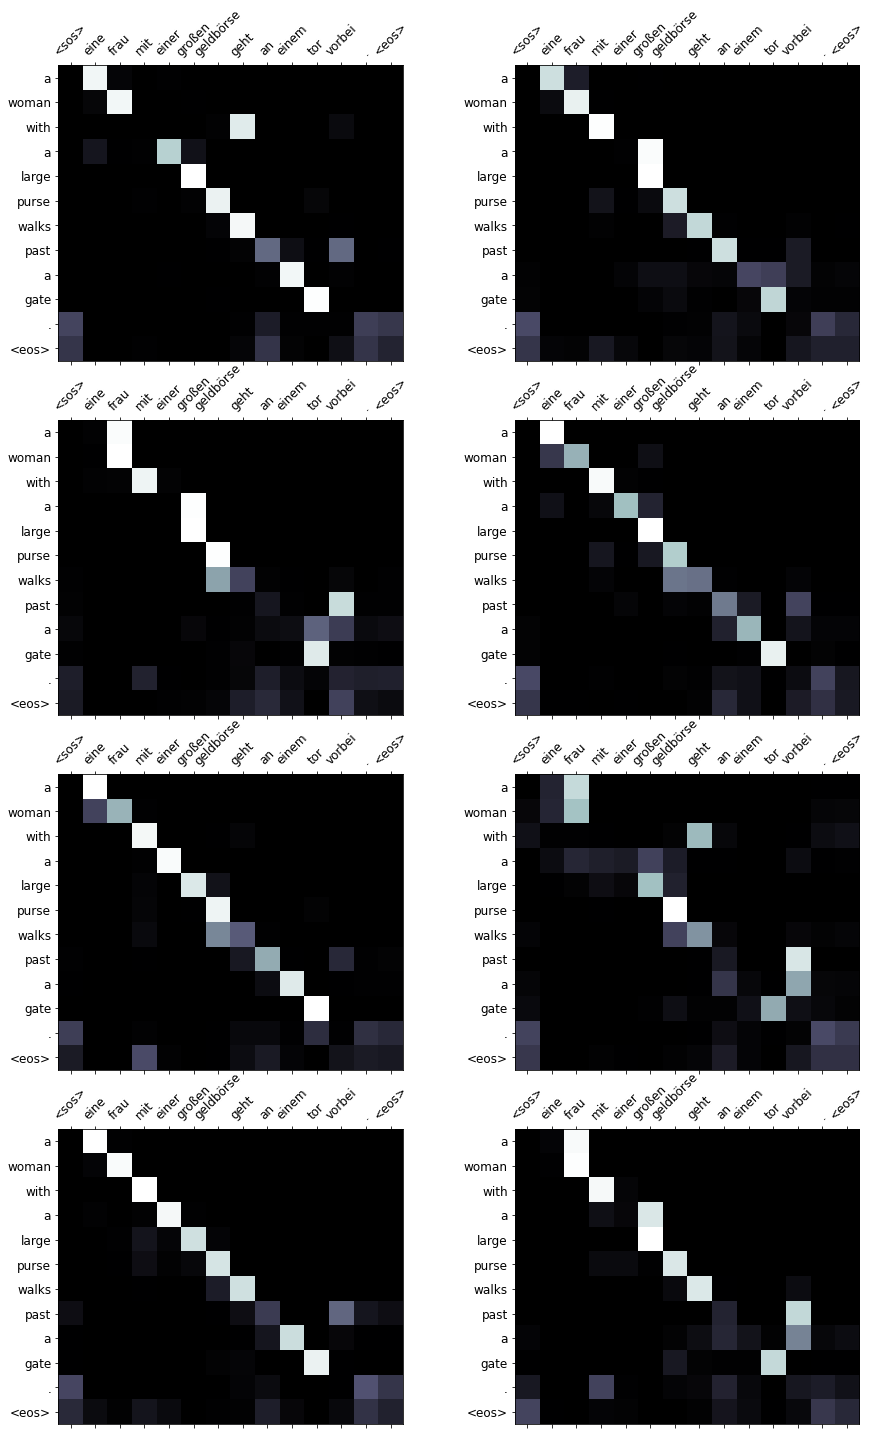

In [34]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [35]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [36]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'a', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


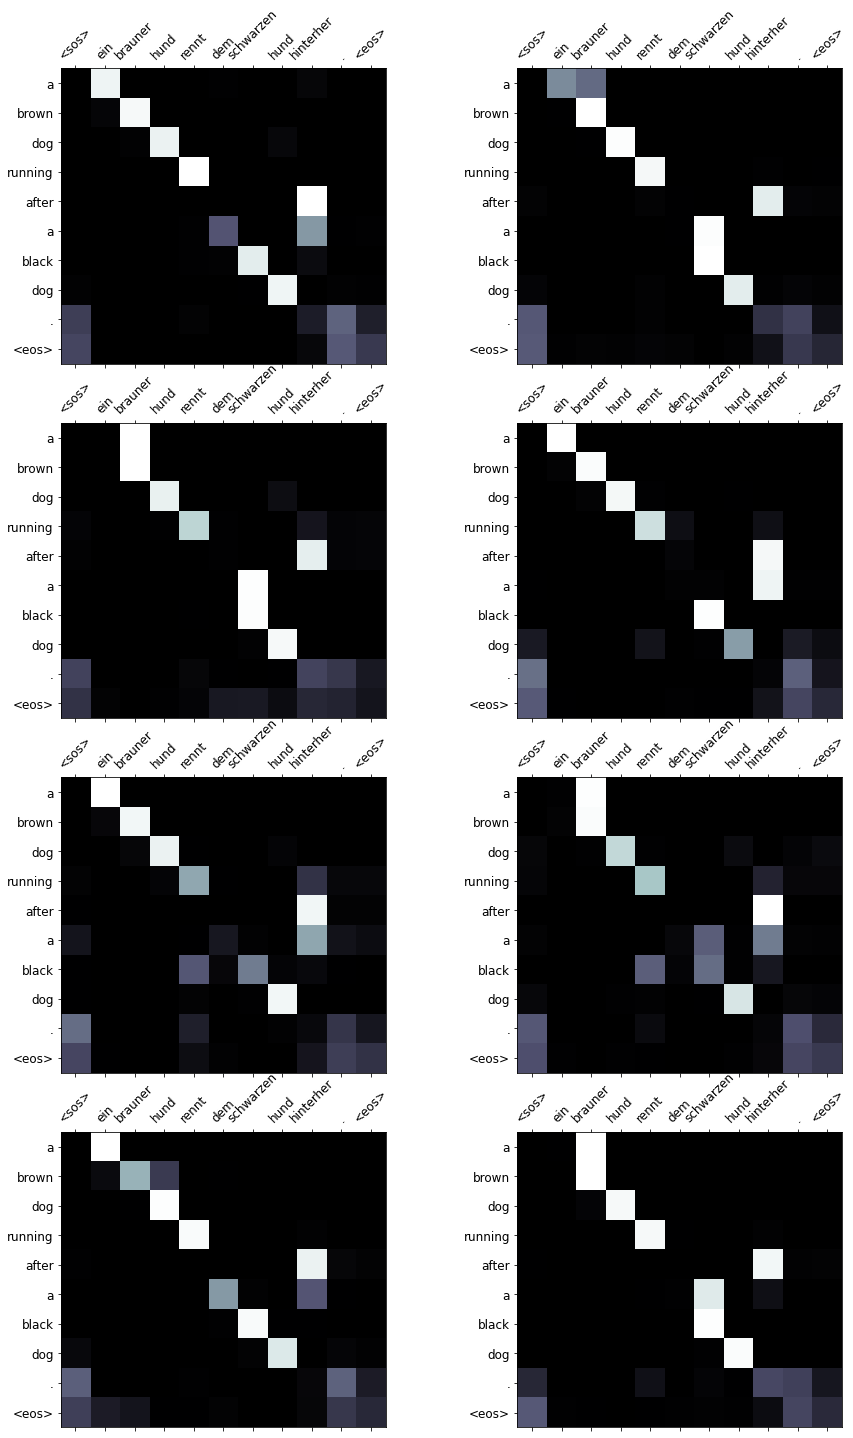

In [37]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [38]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genie√üen', 'einen', 'sch√∂nen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [39]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outdoors', '.', '<eos>']


/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


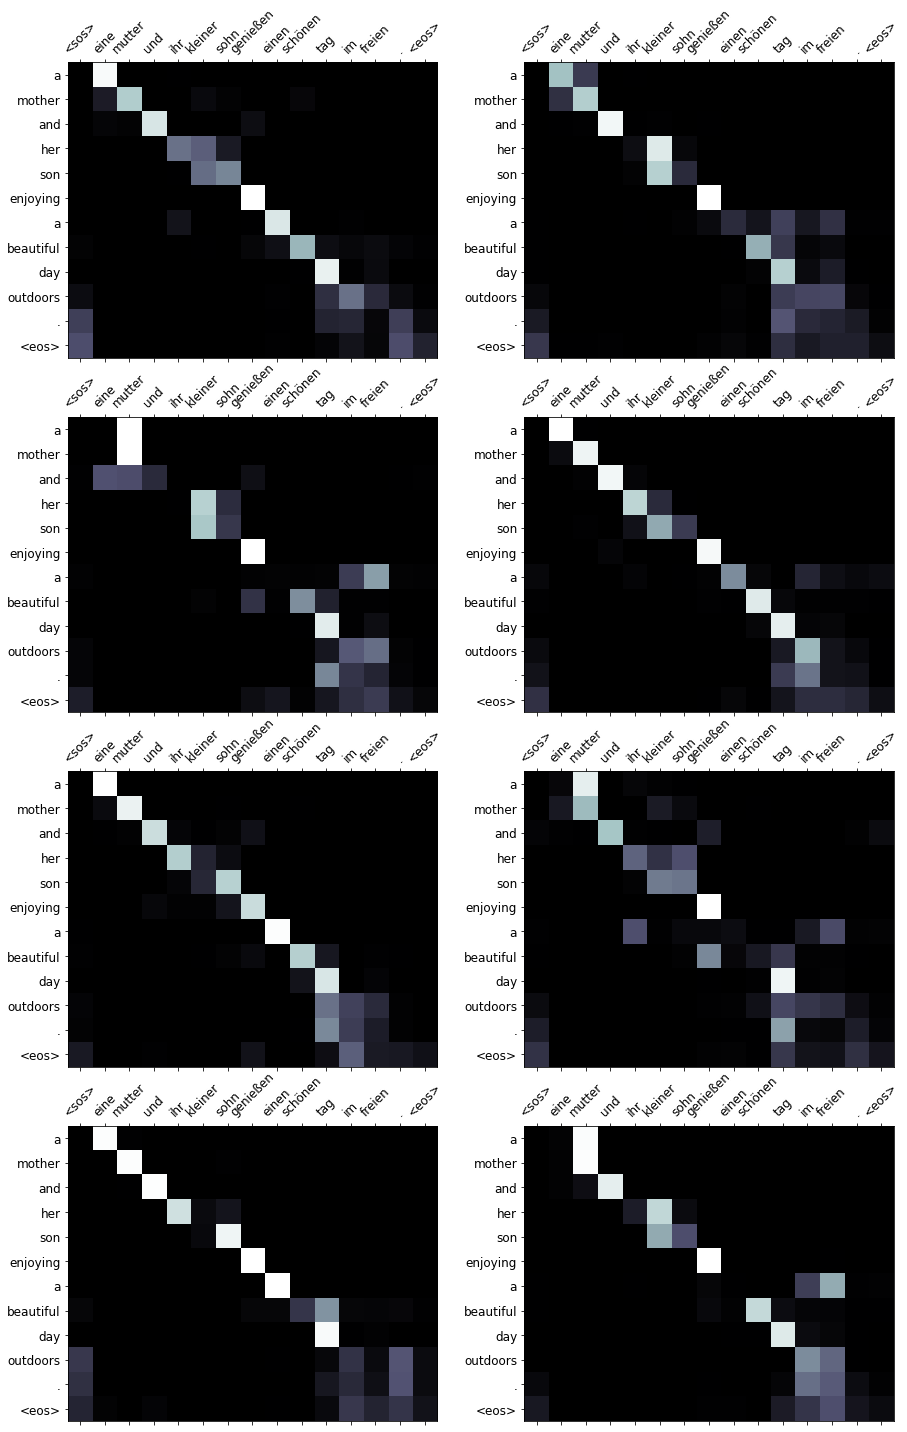

In [40]:
display_attention(src, translation, attention)

ÏúÑÏóê Î≥¥Ïù¥Îäî Î∞îÏôÄ Í∞ôÏù¥ srcÏôÄ trg ÏÇ¨Ïù¥Ïùò attention matrixÍ∞Ä Ï∂úÎ†•ÎêúÎã§.

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [41]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

BLEU score Ï∏°Ï†ïÏùÑ ÌÜµÌï¥ srcÏôÄ trg Î¨∏Ïû•Í∞ÑÏùò Ïú†ÏÇ¨ÎèÑÎ•º Íµ¨ÌïúÎã§.

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [42]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.47


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [43]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [44]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)